### *Neonympha* classificiation with `pytorch` and `fastai`

Chris Hamm - 2019-09-19 (first code)

I have a lot of photos of *Neonympha* butterflies. Can a CNN tell them apart?

### Preliminaries

Prepare the computing environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [4]:
from fastai import *
from fastai.vision import *
batch_size = 64

Set the random seed

In [5]:
np.random.seed(1138)

Read in the data

In [6]:
image_path = '../data/images/'

In [7]:
file_names = get_image_files(image_path)
print(file_names[:4])

[PosixPath('../data/images/Nhe_FL5.JPG'), PosixPath('../data/images/Nmi_1921.JPG'), PosixPath('../data/images/Nmi_1927.JPG'), PosixPath('../data/images/Nfr_4359.JPG')]


Creat the pattern to identify the categories (Nmi, Nfr, Nar, Nhe)

In [8]:
cat_pat = '(N[a-z][a-z])'

In [9]:
image_data = ImageDataBunch.from_name_re(image_path, file_names, \
                                         pat = cat_pat, ds_tfms = get_transforms(), \
                                         size = 224, bs = batch_size)

Normalize the data

In [10]:
image_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (368 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nhe,Nmi,Nfr,Nar,Nmi
Path: ../data/images;

Valid: LabelList (91 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nar,Nar,Nmi,Nmi,Nar
Path: ../data/images;

Test: None

In [11]:
print(image_data.classes)

['Nar', 'Nfr', 'Nhe', 'Nmi']


Print some images

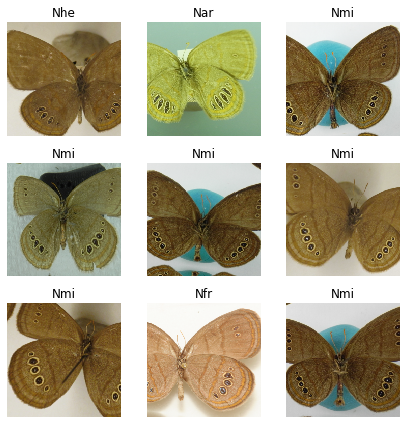

In [12]:
image_data.show_batch(rows = 3, figsize = (6, 6))

In [13]:
len(image_data.classes), image_data.c

(4, 4)

### Train `resnet34`

In [19]:
image_learn = create_cnn(image_data, models.resnet34, metrics = error_rate)

In [20]:
image_learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.935383,0.402444,0.153846,00:30
1,1.204458,0.246140,0.087912,00:30
2,0.838617,0.105498,0.054945,00:30
3,0.667753,0.090514,0.043956,00:30


### Results